# Install Environment

*   For ease of use, we recommend using Google Colab
*   You can also use Jupyter Notebook locally (Desktop,laptop,Server)
*   You can check this link for further [reference](https://towardsdatascience.com/how-to-set-up-anaconda-and-jupyter-notebook-the-right-way-de3b7623ea4a)
* We recommend to install [Anaconda](https://docs.anaconda.com/anaconda/install/index.html) or [Miniconda](https://docs.conda.io/en/latest/miniconda.html) first
* Lastly prepare GPU for faster processing

Most of the new research papers use Python3 as their programming language. 
However, if you use Colab as your training environment, Google will build that for you.
Also, you can activate GPU by changing the Runtime in Google Colab.



# Install libraries
## First install Pytorch
Nowadays, there are many kinds of training framework in the world. Some of which support by tech companies or research centers.
The most common are [PyTorch](https://pytorch.org/) and [Tensorflow](https://www.tensorflow.org).

Here, we will use PyTorch as our framework to build our training scripts. Because it is easy-to-use and being popular for researchers, most of the papers using pytorch as their first selection.
But if in industrial enviroment, TensorFlow would be the better selection for your product.


We will uninstall Tensorflow first

In [43]:
# We won't need TensorFlow here
!pip uninstall -y tensorflow

In [44]:
# install PyTorch
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Utility Functions
Basic utility functions like saving the model to reading the data.
As you can see we use **pickling** to save and load the checkpoints.
You can read more about this here: https://snyk.io/blog/guide-to-python-pickle/

In [45]:
import pickle
import numpy as np
import torch


def pickleStore(savethings, filename):
  # Store the checkpoint
    dbfile = open( filename , 'wb' )
    pickle.dump( savethings , dbfile )
    dbfile.close()
    return


def pikleOpen(filename):
  # Open the model
    file_to_read = open( filename , "rb" )
    p = pickle.load( file_to_read )
    return p


def readData(f):
  # Read Data from the system
    return np.genfromtxt(f, delimiter=',', dtype=str)[1:]


def saveModel(net, path):
  # Save the model
    torch.save(net.state_dict(), path)

# Training Framework
In order to start training, we have to follow these steps:

1.  Dataset
2.  Pre-processing
3.  Dataloader
4.  Model
5.  Training Part and Testing Part
6.  Optimizer
7.  Loss Function


## Dataset
We need to format our data to meet the needs from models. The advantage is we load the data by batch instead of loading all of the dataset into the memory. Here we use the pre-build dataset component.
You also can build your own Dataset object by yourself, and it should follow these methods:
* Declaring it as an extended Dataset Object
* Defining ``__init__``, ``__len__``, ``__getitem__`` functions

In [46]:
import torch


class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, labels, device='gpu'):
        'Initialization'
        self.data = data.to(device)
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.data[index]
        y = self.labels[index]
        return X, y, index

# Pre-processing
We need to pre-process the data before training. Preprocessing helps us to segment more data and clear out anomalies(異常) manually if present.
It also helps us in understanding the data and thus it will eventually help in better performance of the model.

In [47]:
import numpy as np
import torch


def preprocess(data, flip=True):
    date   = data[:, 0]
    open   = data[:, 1]
    high   = data[:, 2]
    low    = data[:, 3]
    close  = data[:, 4]
    volume = data[:, 5]
    #array([105., 112., 110., 118., 120.])
    prices = np.array([close for date, open, high, low, close, volume in data]).astype(np.float64)
    #如果flip為真就使用NumPy的flip()函数将prices数组反转。这个操作可以将数据的时间顺序倒转，用于一些需要倒叙处理数据的模型。
    if flip:
        prices = np.flip(prices)
    #print(prices)
    return prices


def train_test_split(data, percentage=0.8):
    train_size  = int(len(data) * percentage)
    train, test = data[:train_size], data[train_size:]
    return train, test

# 改
def transform_dataset(dataset, look_back=20):
    # N days as training sample
    dataX = [dataset[i:(i + look_back)]
            for i in range(len(dataset)-look_back-1)]
    # 1 day as groundtruth
    dataY = [dataset[i + look_back]
            for i in range(len(dataset)-look_back-1)]
    return torch.tensor(np.array(dataX), dtype=torch.float32), torch.tensor(np.array(dataY), dtype=torch.float32)


# DataLoader
DataLoader provides data to trainer each batch. It fetches the data and indices from dataSet object and combine them as the output.More about parameters:
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.
Fortunately, PyTorch has built in DataLoader function. But if you want to learn more, hit that link above.
One more thing,DO NOT use test data in training.Train data and test data should be mutual exclusive.**BE CAREFUL ABOUT THIS.**


In [48]:
# Demo Code
#from torch.utils.data import DataLoader

# Model
Model is the algorithm of how to map input to label. And it has three methods we need to define: ``__init__``, ``predict`` and ``forward``. 

**DO NOT** declare your forward layer inside forward function, cause in each epoch we need to update the parameters of each layers inside the model.
If training with GPU, **DO NOT** forget to assign the GPU device for your model.
You can see that instead of RNN I have used LSTM.- You can try different methods and experiment.

For more details:
* https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573
* https://ai.stackexchange.com/questions/18198/what-is-the-difference-between-lstm-and-rnn
* https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [49]:
import torch.nn as nn
import torch


class LSTMPredictor(nn.Module):
#改
    def __init__(self, look_back, num_layers=2, dropout=0.3, bidirectional=True):
        #首先调用父类 nn.Module 的构造函数，初始化模型的基本属性。
        super(LSTMPredictor, self).__init__()

        # Nerual Layers LSTM - Long Short Term Memory
        #定义 LSTM 层，输入维度为 look_back，输出维度为 32。这里 num_layers=2 表示 LSTM 层有两层，dropout=0.3 表示在训练时对 LSTM 输出进行 dropout，bidirectional=True 表示使用双向 LSTM。
        self.rnn   = nn.LSTM(look_back, 32, num_layers, dropout=dropout, bidirectional=True)
        #定义一个全连接层，输入维度为 32*(2 if bidirectional else 1)，输出维度为 16。这里 2 if bidirectional else 1 的意思是如果使用双向 LSTM，输入维度需要乘以 2。
        self.ly_a  = nn.Linear(32*(2 if bidirectional else 1), 16)
        # self.ly_a  = nn.Linear(look_back, 16)
        #relu 激活函數
        self.relu  = nn.ReLU()
        self.reg   = nn.Linear(16, 1)

    def predict(self, input):
        with torch.no_grad():
            return self.forward(input).item()
    #forward 函數是nn.Module類中的一個方法
    def forward(self, input):
        r_out, (h_n, h_c) = self.rnn(input.unsqueeze(1), None)
        # print(r_out.shape)
        # input()
        logits = self.reg(self.relu(self.ly_a(r_out.squeeze(1))))
        # logits = self.reg(self.relu(self.ly_a(input)))

        return logits

# Training and Testing part
We finally define the Dataset, DataLoader and Model. But there are still some more things that need to be done. We need to input the data to model, get the predicted output, calculate the criterion and update the parameters of the model.

## Training Function
First is the training part. Training map the relationship between input and label, also update the parameters at the stage.
**DO NOT** forget to move your data to **GPU**, model and data should both at the same place.
One more thing, we suggest writing the checkpoint if your experiment taking too long time.

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')



def trainer(net, criterion, optimizer, trainloader, devloader, epoch_n=100, path="./checkpoint/save.pt"):
    train_losses, valid_losses = [], []
    for epoch in range(epoch_n): # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        train_loss = 0.0
        valid_loss = 0.0
        #对于每个训练样本，使用enumerate()函数获得其索引和数据。
        for i, data in enumerate(trainloader, 0):
            # get the iputs; data is a list of [inputs, labels]
            inputs, labels, data_index = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs.cpu(), labels.unsqueeze(1).cpu())
            train_loss += loss.item()*inputs.shape[0]
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

        ######################    
        # validate the model #
        ######################
        net.eval()
        for i, data in enumerate(devloader, 0):
            # move tensors to GPU if CUDA is available
            inputs, labels, data_index = data
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = net(inputs)
            # calculate the batch loss
            loss = criterion(outputs.cpu(), labels.cpu())
            # update average validation loss 
            valid_loss += loss.item()*inputs.shape[0]
        
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(devloader.dataset)
    
        # print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    print('Finished Training')
    plt.plot(range(1, epoch_n+1), train_losses, label='Training Loss')
    plt.plot(range(1, epoch_n+1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    ## Save model
    saveModel(net, path)

Here,
1. ``optimizer.zero_grad`` means to set the gradient to zero. In each batch, the loss value isaccumulated from the samples' loss value.
2.``criterion`` is a pre-defined function. It is used for calculating the loss value.
3.``loss.backward`` here means to do back propagation based on the loss value and calculate thegradient value.
4.``optimizer.step`` means to do gradient descent. 

More information about gradient descent https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21

## Test Function
Next, we define the testing function. Testing just show how the performance of your model is, it does not upgrade any parameters of the model.

In [51]:
def tester(net, criterion, testloader):
    loss = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels, data_index = data
            outputs = net(inputs)
            loss += criterion(outputs.cpu(), labels.unsqueeze(1).cpu())
    return loss.item()

# Optimizer
Optimizer is the way for models to do gradient discent. It helps model to adjust its parameters. For starters in machine learning, we suggest using
**Adam** as your Optimizer.

In [52]:
# Demo Code
# lr =0.001
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Loss Function
It can be also called as **loss function** or **cost function**. More specific detail please visit:
* https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing
* https://medium.com/@gatorsquare/ml-gradient-descent-%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D%E6%B3%95-c664b5874e5c
A loss function is a function that maps an event or values of one or more variables onto a realnumber intuitively representing some "cost" associated with the event, which measures thepenalty. And an optimization problem seeks to minimize a loss function.

In [53]:
# Demo Code
#criterion = nn.CrossEntropyLoss()

# All set!
A few more steps and then we can start training!

# Import Modules

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data.dataloader import default_collate

import os
import math



## Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the GPU.



In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Read Data

In [56]:
data = readData("0050_history.csv")
print('Num of samples:', len(data))

Num of samples: 3724


# Preprocess

In [57]:
prices = preprocess(data)
# Divide trainset and test set
train, test = train_test_split(prices, 0.8)
# Set the N(look_back)=5 because from the five day stock, we are predicting the next day
look_back = 5
trainX, trainY = transform_dataset(train, look_back)
testX, testY   = transform_dataset(test, look_back)
# Get dataset
trainset = Dataset(trainX, trainY, device)
testset  = Dataset(testX, testY, device)
# Get dataloader
#改
batch_size = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0) # num_workers should set 1 if put data on CUDA
testloader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# Model Initialize

In [58]:
net = LSTMPredictor(look_back)
net.to(device)

LSTMPredictor(
  (rnn): LSTM(5, 32, num_layers=2, dropout=0.3, bidirectional=True)
  (ly_a): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (reg): Linear(in_features=16, out_features=1, bias=True)
)

# Loss Function

In [59]:
#改
criterion = nn.MSELoss() # Feel free to use any other loss

I used Mean Square Error Loss function. You can tweak with other if you want.
https://pytorch.org/docs/stable/nn.html#loss-functions

Or, you can create your own loss function 
https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b


# Optimizer

In [60]:
#改
optimizer = optim.Adam(net.parameters(), lr=0.001) # you can tweak the lr and see if it affects anything

# Training

You can change the epoch here.
But also make sure it doesn't overfit!

[1,    10] loss: 35.340
[1,    20] loss: 34.822
[1,    30] loss: 34.871
	Training Loss: 6992.617670 	Validation Loss: 2368.192262
[2,    10] loss: 33.511


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2,    20] loss: 31.036
[2,    30] loss: 30.714
	Training Loss: 6350.963278 	Validation Loss: 1805.716428
[3,    10] loss: 27.985
[3,    20] loss: 26.579
[3,    30] loss: 24.215
	Training Loss: 5255.596678 	Validation Loss: 1146.567939
[4,    10] loss: 21.796
[4,    20] loss: 21.063
[4,    30] loss: 17.443
	Training Loss: 4026.379943 	Validation Loss: 555.544335
[5,    10] loss: 16.622
[5,    20] loss: 13.822
[5,    30] loss: 12.067
	Training Loss: 2844.575503 	Validation Loss: 176.931280
[6,    10] loss: 11.268
[6,    20] loss: 8.646
[6,    30] loss: 8.299
	Training Loss: 1882.875349 	Validation Loss: 81.230965
[7,    10] loss: 7.091
[7,    20] loss: 5.821
[7,    30] loss: 5.618
	Training Loss: 1238.796449 	Validation Loss: 228.529571
[8,    10] loss: 4.668
[8,    20] loss: 4.361
[8,    30] loss: 4.381
	Training Loss: 892.936406 	Validation Loss: 484.776157
[9,    10] loss: 3.880
[9,    20] loss: 3.650
[9,    30] loss: 3.793
	Training Loss: 754.845091 	Validation Loss: 715.890486
[10,

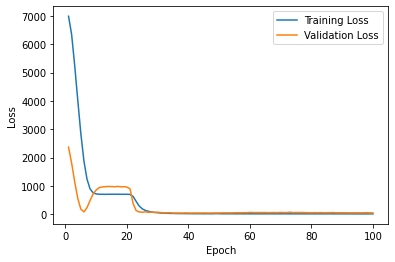

In [61]:
## Training
checkpoint = "./checkpoint/save.pt"
if not os.path.isfile(checkpoint):
  os.makedirs("./checkpoint")
  #改
  trainer(net, criterion, optimizer, trainloader, testloader, epoch_n=100, path=checkpoint)
else:
  net.load_state_dict(torch.load(checkpoint))

# Test the Data
Now let's compare with the test data

In [62]:
test = tester(net, criterion, testloader)
# Show the difference between predict and groundtruth (loss)
print('Test Result: ', test)

Test Result:  27.546098709106445


# Predict
Our model is now ready! 

Let's try with some sample data!
Suppose the closing data, 
* Monday = 126
* Tuesday = 124
* Wednesday = 124
* Thursday = 122.5
* Friday = 121

So, the model is predicting the next day given the input of 5 day closing values

In [63]:
predict = net.predict(torch.tensor([[126, 124, 124, 122.5, 121]], dtype=torch.float32).to(device))
print('Predicted Result', predict)

Predicted Result 109.35045623779297


What can you do to improve the performance?

* Increase the epoch
* You can use multiple input data (Maybe closing data and volume has a relation!)
* Try out different loss function
* Evaluate the test data and training data and see the accuracy 
* Experiment with the code

# Report Guidelines
In the field of Computer Science, most of the latest techniques are proposed at conferences instead of journal, like NIPS, ACL, CVPR, AAAI and so on.

We will follow IEEE guidelines to write paper report.
A proper report will contain-
 * Abstract
 * Introduction
 * Methods
 * Experiment
 * Results
 * Conclusion 
 * References
 For more details: https://www.ieee.org/conferences/publishing/templates.html
 We recommend to use overleaf latex Editor.

# Grading
 Grading is based on your report.
Below are the grading policy for this homework:
* The report should be in English.
* Introduction & Conclusion (30%)
* Methods (30%)
* Experiment & Results (30%)
* Abstract & References (10%)

# Final Project
We suggest selecting one interesting topic as early as possible. Most of the students here are undergraduate or new to coding, it would be the best time for you to develop your knowledge and the ability to implement code by reading research papers. 


# Papers
You can find papers here:
* https://arxiv.org
* Google Scholar
* Conference Websites